### installs

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00


### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import wandb

### wandb setup

In [ ]:
use_wandb = False #set to true and add your key for model versioning in wandb
if use_wandb:
  wandb.login(key="YOUR WANDB KEY HERE")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## data

### Load in and data

Data from here: [PDSI data](https://data.world/us-hhs-gov/c74010cf-8b86-4be4-bd25-5366d8004d82),
[SPI data](https://data.world/us-hhs-gov/ea3a3271-8895-410c-8cc7-2b214496969b)

In [ ]:
palmer = pd.read_csv("/content/palmer.csv")
spi = pd.read_csv("/content/SPI.csv")

### data cleaning

In [ ]:
palmer["date"] = pd.to_datetime(palmer.year.astype(str) + '/' + palmer.month.astype(str) + '/01')
palmer = palmer.sort_values(by='date')
#get rid of counties that are not in the SPI dataset
palmer = palmer[palmer["countyfips"] != 51620]
palmer = palmer[palmer["countyfips"] != 12009]
palmer = palmer[palmer["countyfips"] != 51595]
palmer = palmer[palmer["countyfips"] != 51610]
palmer = palmer[palmer["countyfips"] != 51515]


spi["date"] = pd.to_datetime(spi.year.astype(str) + '/' + spi.month.astype(str) + '/01')
spi = spi.loc[spi['spi'] != -99.99] #they put empty values as -99.99
spi = spi.sort_values(by='date')

print("all counties: ", palmer["countyfips"].unique())

all counties:  [ 1001 42057 42059 ...  1025  1005  1003]


### data visualization

In [ ]:
'''
# data visualization
tempSPI = spi[spi["countyfips"] == 1001]
plt.plot(tempSPI['date'], tempSPI['spi'])

tempPalmer = palmer[palmer["countyfips"] == 1001]
plt.plot(tempPalmer['date'], tempPalmer['pdsi'])

plt.show()
'''

'\n# data visualization\ntempSPI = spi[spi["countyfips"] == 1001]\nplt.plot(tempSPI[\'date\'], tempSPI[\'spi\'])\n\ntempPalmer = palmer[palmer["countyfips"] == 1001]\nplt.plot(tempPalmer[\'date\'], tempPalmer[\'pdsi\'])\n\nplt.show()\n'

### combining data tables

In [ ]:
palmerCounty = palmer[palmer.countyfips == 42057]
palmerCounty = palmerCounty[["date", "pdsi"]]
spiCounty = spi[spi.countyfips == 42057]
spiCounty = spiCounty[["date", "spi"]]
new_df = palmerCounty.merge(spiCounty, on=['date'])
# #normalize
# temp = new_df[["pdsi", "spi"]]
# new_df[["pdsi", "spi"]]=(temp-temp.mean())/temp.std()

### hold out data for val

In [ ]:
# Hold out 30 percent of data to do validation
train = new_df[new_df.date < np.min(new_df.date)+((np.max(new_df.date)-np.min(new_df.date))*0.7)]

dataset_train = train[["pdsi"]] #spi
# print(dataset_train.shape)
print(dataset_train.head())
dataset_train = np.reshape(np.array(dataset_train), (-1,1))
val = new_df[new_df.date > np.min(new_df.date)+((np.max(new_df.date)-np.min(new_df.date))*0.7)]
dataset_test = val.pdsi #spi
dataset_test = np.reshape(np.array(dataset_test), (-1,1))

    spi
0  0.89
1 -1.18
2 -0.92
3 -0.36
4 -0.58


## model

credit for code inspiration: https://www.kaggle.com/code/abhishekmamidi/time-series-analysis-artificial-neural-networks

### scaling data

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
# scaled_train = dataset_train
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
# scaled_test = dataset_test

### configs

In [ ]:
config = {
    "sequence_length": 100, # Number of time steps to look back for training
    "sequence_length_test": 100,  # Number of time steps to look back for testing
    "input_size": 1,
    "num_layers": 4,
    "hidden_size": 28,
    "output_size": 1,
    "batch_size": 16,
    "num_epochs": 20,
    "dropout": 0.5
}

### data

In [ ]:
X_train, y_train = [], []
for i in range(len(scaled_train) - config["sequence_length"]):
    X_train.append(scaled_train[i:i+config["sequence_length"]])
    y_train.append(scaled_train[i+1:i+config["sequence_length"]+1])
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape


# Create sequences and labels for testing data
X_test, y_test = [], []
for i in range(len(scaled_test) - config["sequence_length_test"]):
    X_test.append(scaled_test[i:i+config["sequence_length_test"]])
    y_test.append(scaled_test[i+1:i+config["sequence_length_test"]+1])
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([339, 100, 1]), torch.Size([339, 100, 1]))

In [ ]:
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

# Create DataLoader for batch test
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

### model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units
      # num_layers : number of LSTM layers
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=config["dropout"])
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

### defining things

In [ ]:
# Define the model, loss function, and optimizer
model = LSTMModel(config["input_size"], config["hidden_size"], config["num_layers"]).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=0.001)

### training

In [ ]:
if use_wandb:
  run = wandb.init(
    name = "42057 county change", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # id = "n37w794d", ### Insert specific run id here if you want to resume a previous run
    # resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "drought_prediction-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
  )

lr,██████████▃▃▃▃▃▃▁▁▁▁
train_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▂▁▁▁▁▂▁▂▂▁▂▁▂▂▂▂▂▂▂
lr,0.0025
train_loss,0.35603
valid_loss,0.29708


In [ ]:
if use_wandb:
  ### Save your model architecture as a string with str(model)
  model_arch  = str(model)

  ### Save it in a txt file
  arch_file   = open("model_arch.txt", "w")
  file_write  = arch_file.write(model_arch)
  arch_file.close()

  ### log it in your wandb run with wandb.save()
  wandb.save('model_arch.txt')

  ### Save it in a txt file
  config_str = str(config)
  config_file   = open("configs.txt", "w")
  file_write  = config_file.write(config_str)
  config_file.close()

  ### log it in your wandb run with wandb.save()
  wandb.save('configs.txt')

['/content/wandb/run-20240418_000609-s656tq44/files/configs.txt']

In [ ]:
# Training loop

for epoch in range(config["num_epochs"]):
  total_loss = 0.0
  # Training
  model.train()
  curr_lr = float(optimizer.param_groups[0]['lr'])
  batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
  for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    predictions = model(batch_X)
    loss = loss_fn(predictions, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    total_loss += loss.item()
    batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))


    batch_bar.update() # Update tqdm bar

  # Calculate average training loss and accuracy
  average_loss = total_loss / len(train_loader)
  batch_bar.close() # You need this to close the tqdm bar

  # Validation on test data
  model.eval()
  with torch.no_grad():
    total_val_loss = 0.0

    for batch_X_test, batch_y_test in test_loader:
      batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
      predictions_test = model(batch_X_test)
      val_loss = loss_fn(predictions_test, batch_y_test)

      total_val_loss += val_loss.item()

    # Calculate average test loss and accuracy
    average_val_loss = total_val_loss / len(test_loader)
  if use_wandb:
    wandb.log({
          'train_loss': total_loss,
          'valid_loss': total_val_loss,
          'lr'        : curr_lr
      })

  scheduler.step(total_val_loss)
  if (epoch+1):
    print(f'Epoch [{epoch+1}/{config["num_epochs"]}] - Training Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')


Epoch [1/20] - Training Loss: 0.0300, Val Loss: 0.0318


Epoch [2/20] - Training Loss: 0.0258, Val Loss: 0.0317


Epoch [3/20] - Training Loss: 0.0258, Val Loss: 0.0316


Epoch [4/20] - Training Loss: 0.0257, Val Loss: 0.0315


Epoch [5/20] - Training Loss: 0.0257, Val Loss: 0.0317


Epoch [6/20] - Training Loss: 0.0256, Val Loss: 0.0315


Epoch [7/20] - Training Loss: 0.0256, Val Loss: 0.0317


Epoch [8/20] - Training Loss: 0.0257, Val Loss: 0.0316


Epoch [9/20] - Training Loss: 0.0256, Val Loss: 0.0316


Epoch [10/20] - Training Loss: 0.0256, Val Loss: 0.0316


Epoch [11/20] - Training Loss: 0.0255, Val Loss: 0.0317


Epoch [12/20] - Training Loss: 0.0254, Val Loss: 0.0319


Epoch [13/20] - Training Loss: 0.0252, Val Loss: 0.0324


Epoch [14/20] - Training Loss: 0.0247, Val Loss: 0.0332


Epoch [15/20] - Training Loss: 0.0244, Val Loss: 0.0340


Epoch [16/20] - Training Loss: 0.0251, Val Loss: 0.0316


Epoch [17/20] - Training Loss: 0.0250, Val Loss: 0.0327


Epoch [18/20] - Training Loss: 0.0244, Val Loss: 0.0336


Epoch [19/20] - Training Loss: 0.0234, Val Loss: 0.0346


Epoch [20/20] - Training Loss: 0.0229, Val Loss: 0.0356


In [ ]:
run.finish()

### testing

In [ ]:
# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()
# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
	for _ in range(config["sequence_length_test"]):
		# Prepare the historical_data tensor
		historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
		# Use the model to predict the next value
		predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

		# Append the predicted value to the forecasted_values list
		forecasted_values.append(predicted_value[0])

		# Update the historical_data sequence by removing the oldest value and adding the predicted value
		historical_data = np.roll(historical_data, shift=-1)
		historical_data[-1] = predicted_value

<ipython-input-55-3ea3cce933e2>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


### Ploting results

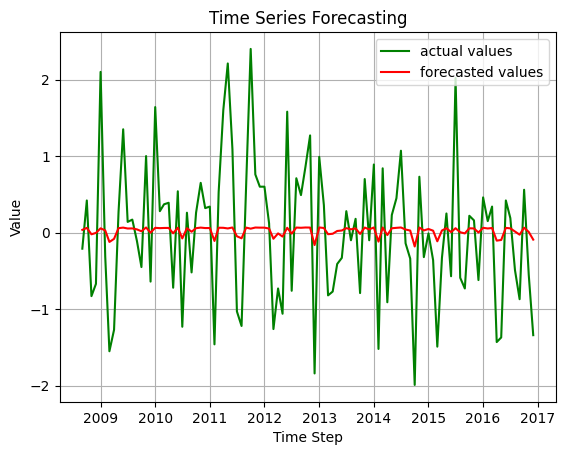

In [ ]:
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()
# original_cases = np.expand_dims(sequence_to_plot[-1], axis=0).reshape((-1,))
plt.plot(val.date[-config["sequence_length"]:], original_cases, label='actual values', color='green')

#Forecasted Values
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
# forecasted_cases = np.expand_dims(forecasted_values, axis=0).reshape((-1,))
# plotting the forecasted values
plt.plot(val.date[-config["sequence_length"]:], forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)

plt.show()